### Martin Borus, @mborus, #bcki19
-------------------------------------------
# Kundendaten auf einer Landkarte anzeigen
--------------------------------------------
## Links

Software:

- python3 http://python.org
- jupyter-lab https://jupyterlab.readthedocs.io/en/stable/
- pandas: https://pandas.pydata.org/ (seit 2009/2014)
- geopandas: http://geopandas.org/ (seit 2013)
- matplotlib: https://matplotlib.org/

- windows binarys: https://www.lfd.uci.edu/~gohlke/pythonlibs/

Daten-Downloads:
- https://www.naturalearthdata.com/downloads/
- https://opendata-esri-de.opendata.arcgis.com/datasets/3c1f46241cbb4b669e18b002e4893711_0?geometry=-11.712%2C46.271%2C61.413%2C55.888
- https://launix.de/launix/launix-gibt-plz-datenbank-frei/


In [1]:
# Import von Libraries

import pandas as pd
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Polygon, Point, box
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.colors 
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rc('figsize=(20, 20)')
from pathlib import Path

In [2]:
BASE = Path(r'd:\barcamp')

In [3]:
# PLZUMSATZ
PLZUMSATZ = BASE / r'fake_umsatz_einzelposten_plz.csv'

# https://www.naturalearthdata.com/downloads/
MAPDATA = BASE / 'ne_10m_admin_1_states_provinces' / 'ne_10m_admin_1_states_provinces.shp'

# Gridfile
# https://opendata-esri-de.opendata.arcgis.com/datasets/3c1f46241cbb4b669e18b002e4893711_0?geometry=-11.712%2C46.271%2C61.413%2C55.888
GRIDFILE = BASE / r'Hexagone_125_km\Hexagone_125_km.shp'

# Zuordnungstabelle PLZ zu Koordinaten
PLZGEODATEN = BASE / r'geodaten_de.csv'

#EXPORTE
# lat/lon + Summe Umsatz, für's Grid
KUNDENGEOUMSATZ = BASE / r'umsatz_kunden_geo.csv'


In [4]:
df = pd.read_csv(PLZUMSATZ, sep=';',  dayfirst=True,  dtype={1: str})

In [5]:
# Anzahl der Zeilen zeigen
len(df)

143158

In [6]:
# Beispiel
df.sample(10)

,datum,plz,gezahlt,betrag
131335,03.04.19,24837,-5.09,0.00
17612,14.05.18,24992,0.86,0.00
121128,17.12.18,25878,0.00,-0.16
136948,22.04.19,24939,0.00,6.37
34797,08.06.18,25813,5.10,0.00
128251,22.03.19,25813,0.00,14.85
35318,10.06.18,24852,0.00,4.34
108122,04.10.18,24941,0.00,1.74
24688,24.05.18,24912,0.40,0.00
81029,16.08.18,24960,0.00,7.92


In [7]:
df.loc[:, 'datum'] = pd.to_datetime(df.datum, dayfirst=True)
df = df.set_index('datum')
df.head()

,plz,gezahlt,betrag
datum,,,
2018-01-01,24837,1.44,0.0
2018-01-01,24941,0.72,0.0
2018-01-01,25856,0.43,0.0
2018-01-01,25813,1.44,0.0
2018-01-01,24941,1.73,0.0


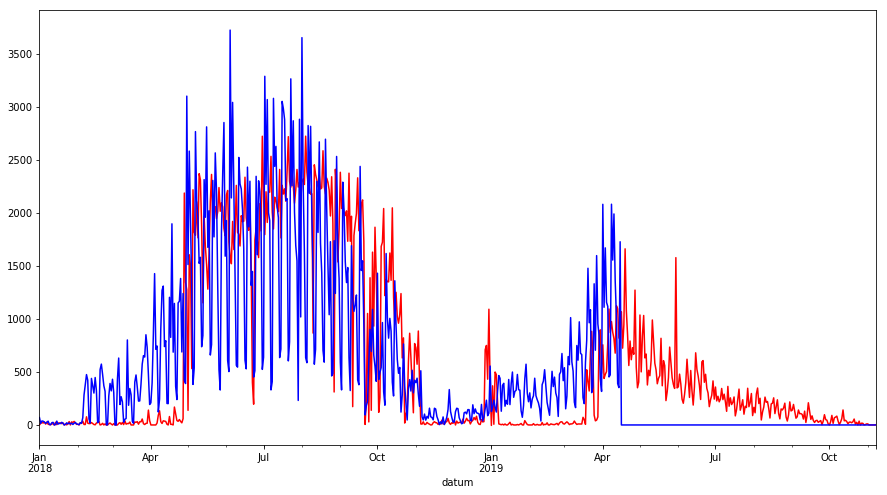

In [8]:
plt.figure(figsize=(15, 8))
ax1 = df['betrag'].resample('D').sum().plot(color='red')
ax2 = df['gezahlt'].resample('D').sum().plot(color='blue')
plt.show()

In [9]:
s_umsatz = df.fillna(value={'plz':'XXXXX'}).groupby('plz')['betrag'].sum().fillna(0.0)


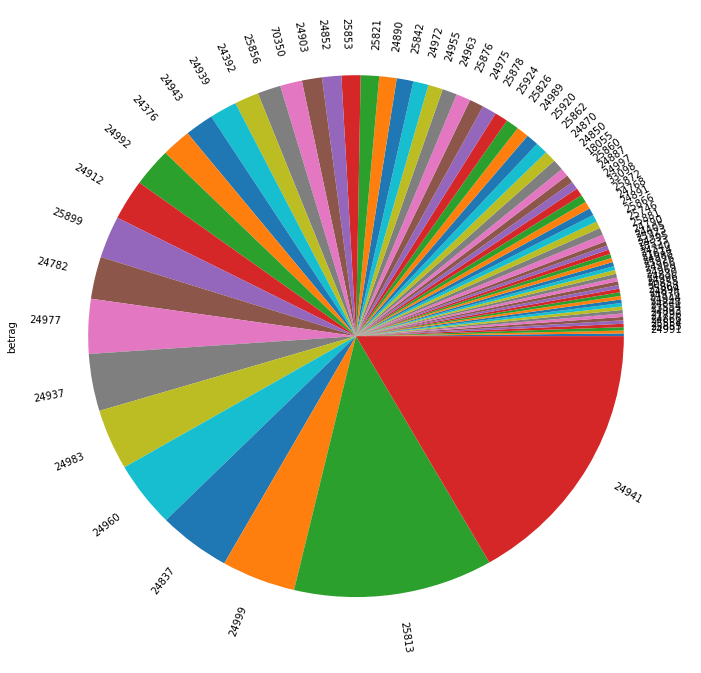

In [10]:
s_umsatz.sort_values().plot(kind='pie', legend=False, rotatelabels=True, figsize=(12, 12));

In [11]:
df_plz = pd.read_csv(PLZGEODATEN, sep=';', dtype='str', encoding='latin-1').set_index('Plz')

In [12]:
df_plz['betrag'] = s_umsatz

In [15]:
df_plz.sample(10)

,Ort,Longitude,Latitude,betrag
Plz,,,,
47546,Kalkar,51.7506,6.31019,NaN
27638,Wremen,53.6427,8.53318,NaN
81375,München,48.1214,11.4852,NaN
07616,Bürgel,50.9557,11.7799,NaN
99846,Seebach,50.9141,10.425,NaN
96188,Stettfeld,49.9791,10.7321,NaN
87675,Stötten am Au,47.7439,10.7117,NaN
86441,Zusmarshausen,48.408,10.5983,NaN
24814,Sehestedt,54.3711,9.82347,NaN


In [14]:
df_plz_u = df_plz[~df_plz.betrag.isnull()]

In [16]:
df_plz.sample(10)

,Ort,Longitude,Latitude,betrag
Plz,,,,
97258,Ippesheim,49.5855,10.1573,NaN
88454,Hochdorf,48.0223,9.79132,NaN
81677,München,48.1403,11.6318,NaN
06458,Hedersleben,51.8643,11.2865,NaN
74862,Binau,49.3738,9.07505,NaN
32694,Dörentrup,52.0365,9.02894,NaN
86405,Meitingen,48.5468,10.8332,NaN
16352,Basdorf,52.6907,13.4496,NaN
39646,Oebisfelde,52.4532,11.0224,NaN


In [17]:
df_plz_u.to_csv(KUNDENGEOUMSATZ, sep=';', index=False, header=None)

# Deutschlandkarte vorbereiten


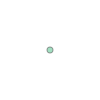

In [18]:
# Geodaten Flensburg Point(9.4469964, 54.7937431) 

# Geodaten Kiel
# Breitengrad, Längengrad
Point(10.1220208, 54.3418554)

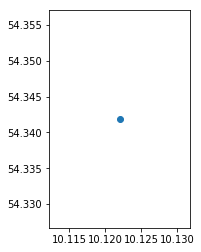

In [19]:
# Geodaten Flensburg

# gdf_p = gpd.GeoDataFrame(['flensburg'], geometry=[Point(9.4469964, 54.7937431)])
gdf_p = gpd.GeoDataFrame(['kiel'], geometry=[Point(10.1220208, 54.3418554)])
gdf_p.plot();

In [20]:
world = gpd.read_file(str(MAPDATA))

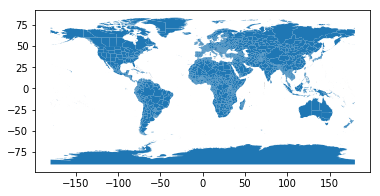

In [21]:
world.plot()

In [22]:
gdf_ger = world[world['iso_a2'].isin(['DE'])]

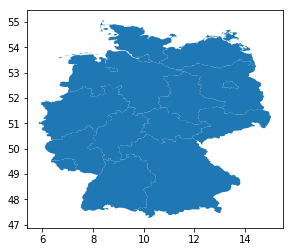

In [23]:
gdf_ger.plot()

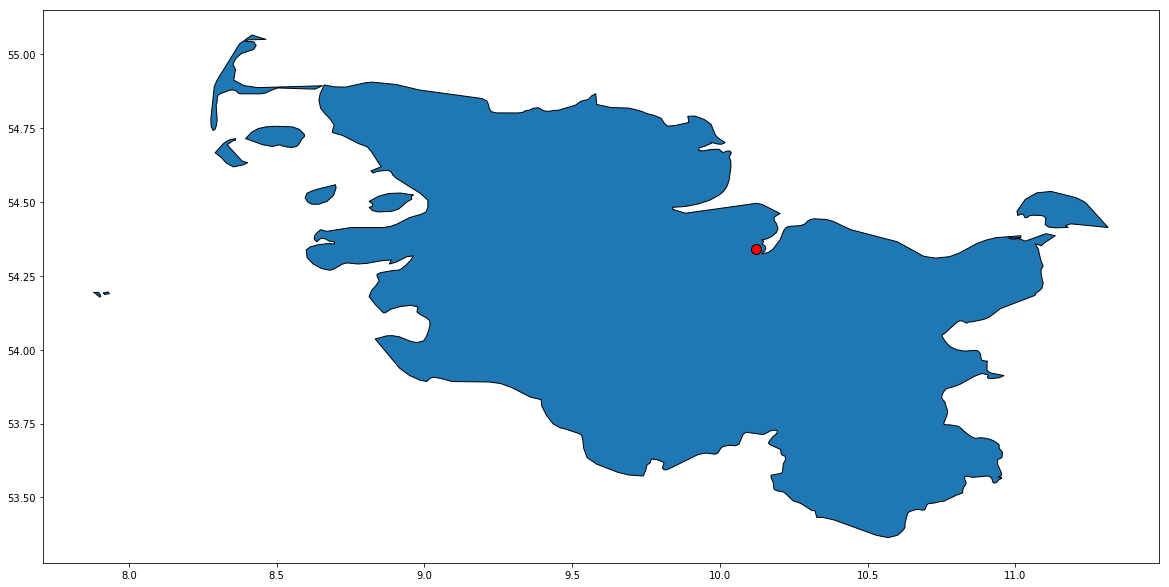

In [24]:
fig, ax = plt.subplots(figsize=(20,20))
gdf_ger[gdf_ger.name=='Schleswig-Holstein'].plot(ax=ax, edgecolor="black")
gdf_p.plot(ax=ax, markersize=100, color='red', edgecolor='black')

In [25]:
gdf_ger_box = gpd.GeoDataFrame(
# [ 5.85248987 47.27112091 15.02205937 55.06533438]
# add some border    
[box(5.3, 46.7, 15.5, 55.5)],
    columns = ['geometry'],
    geometry='geometry',
crs = gdf_ger.crs)

gdf_ger_inv = gpd.tools.overlay(gdf_ger, 
                                gdf_ger_box, 
                                how="symmetric_difference")


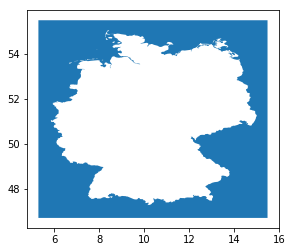

In [26]:
gdf_ger_inv.plot()

# Umsätze ins Grid laden


In [27]:
gdf_grid = gpd.read_file(str(GRIDFILE))

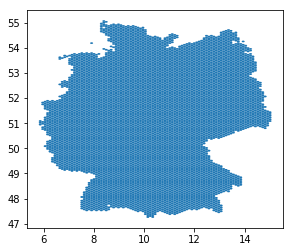

In [28]:
gdf_grid.plot()


In [29]:
str(gdf_grid.iloc[0].geometry)

'POLYGON ((10.2098818832243 47.2701236046314, 10.1774667223726 47.2320133080276, 10.112636400669 47.2320133080276, 10.0802212398173 47.2701236046314, 10.112636400669 47.308206479183, 10.1774667223726 47.308206479183, 10.2098818832243 47.2701236046314))'

In [30]:
KUNDENGEOUMSATZ

WindowsPath('d:/barcamp/umsatz_kunden_geo.csv')

In [31]:
dfu = pd.read_csv(KUNDENGEOUMSATZ, sep=';', header=None)
dfu.columns = 'ort', 'lat', 'lon', 'sum'

In [32]:
dfu.sample(5)

,ort,lat,lon,sum
43,Wilster,53.9318,9.35920,848.96
45,Husum,54.4630,9.06072,49530.40
49,Drelsdorf,54.5929,9.06630,4738.74
53,Joldelund,54.6652,9.12667,3056.14
56,Ostenfeld (Husum),54.4648,9.25296,1888.43


In [33]:
gdfu = gpd.GeoDataFrame(dfu.copy(), geometry=[Point(x,y) for x,y in zip(dfu.lon, dfu.lat)])

In [34]:
gdfu.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 5 columns):
ort         67 non-null object
lat         67 non-null float64
lon         67 non-null float64
sum         67 non-null float64
geometry    67 non-null object
dtypes: float64(3), object(2)
memory usage: 2.7+ KB


In [35]:
gdfu.sample(5)

,ort,lat,lon,sum,geometry
23,Flensburg,54.8044,9.41899,6816.03,POINT (9.418989999999999 54.8044)
21,Tolk,54.5970,9.65311,891.52,POINT (9.65311 54.597)
48,Langenhorn,54.6867,8.91947,4153.27,POINT (8.91947 54.6867)
65,Langenhagen,52.4734,9.69751,917.82,POINT (9.697510000000001 52.4734)
42,Wees,54.8086,9.53498,18419.37,POINT (9.534980000000001 54.8086)


In [36]:
spatial_index = gdfu.sindex

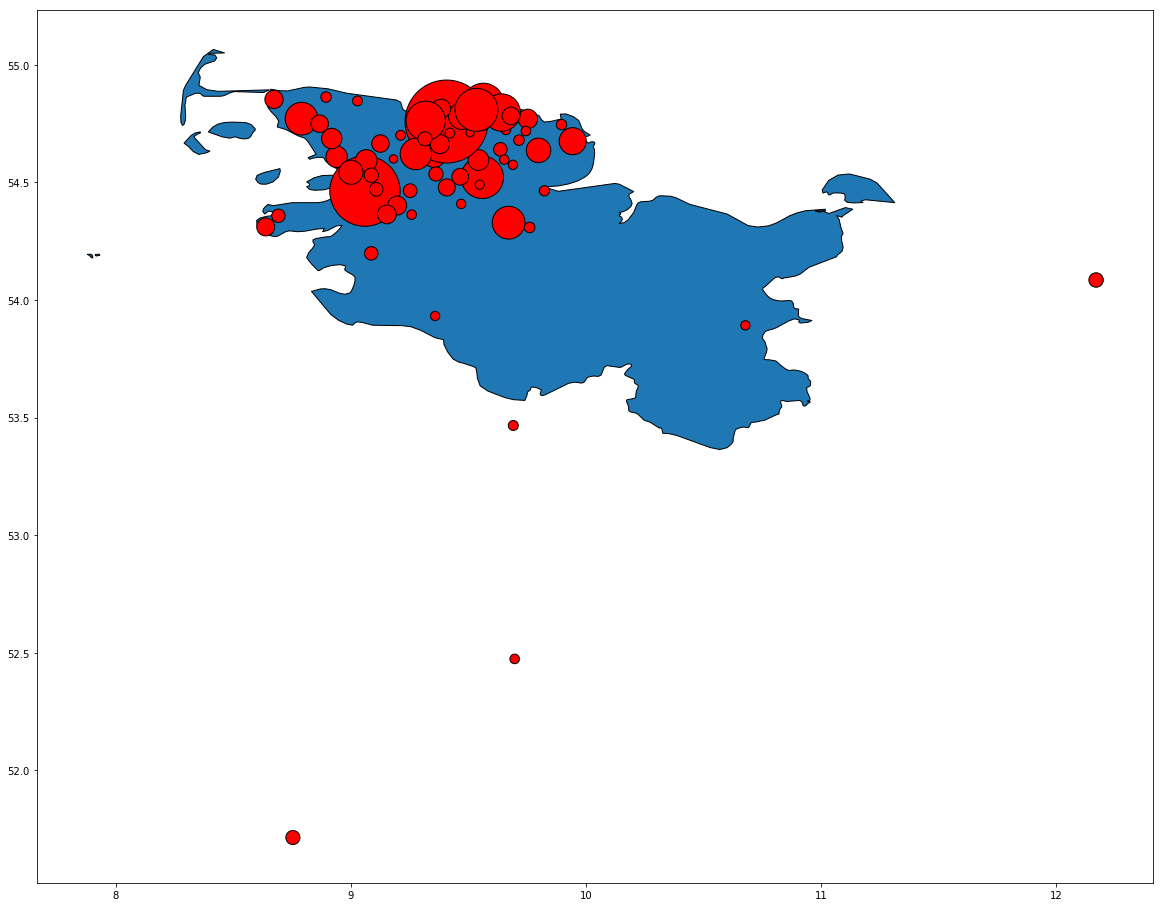

In [37]:
fig, ax = plt.subplots(figsize=(20,20))
gdf_ger[gdf_ger.name=='Schleswig-Holstein'].plot(ax=ax, edgecolor="black")
gdfu.plot(ax=ax, markersize=gdfu['sum'] / 10, color='red', edgecolor='black');

In [38]:
# Leere Liste für die Summen
sum_hex = []

# für jedes Hex im Deutschland Grid
for index, row in tqdm(gdf_grid.iterrows()):

    # Besorge die Geometrie des Hex
    polygon = row.geometry
    
    # Matche gegen eine Box, die das Hex umgibt.
    # Ergebnis: Der Index der Punkte, die in der Box sind
    possible_matches_index = list(spatial_index.intersection(polygon.bounds))
    
    # Finde die Punkte zu diesem Index
    possible_matches = gdfu.iloc[possible_matches_index]
    
    # Prüfe diese Punkte, ob sie im Hex sind
    # Ergebnis: GeoDataFrame gefiltert auf Zeilen, die im hex sind
    precise_matches = possible_matches[possible_matches.within(polygon)]
    
    # Summiere die Spalte "sum" in dieser Abgrenzung und füge sie einer Liste zu
    sum_hex.append(sum(precise_matches['sum']))
        

7127it [00:20, 343.89it/s]


In [39]:
gdf_grid.loc[:,'sum'] = sum_hex

In [40]:
gdf_grid_filtered = gdf_grid[gdf_grid['sum'] > 0.0]

In [41]:
levels = [0, 1, 1000, 10000, 25000, 50000, 100000, 500000, 1000000]
colors = ['black', 'darkgrey', 'grey', 'yellow', 'green', 'red', 'orange', 'white']
cmap, norm =  matplotlib.colors.from_levels_and_colors(levels, colors)

# gdf_grid.plot(ax=ax, column='sum', edgecolor='none', cmap='hot', linewidth=0.001, legend=True)
# gdf_grid_filtered.plot(ax=ax, column='sum', edgecolor='face', cmap=cmap

''

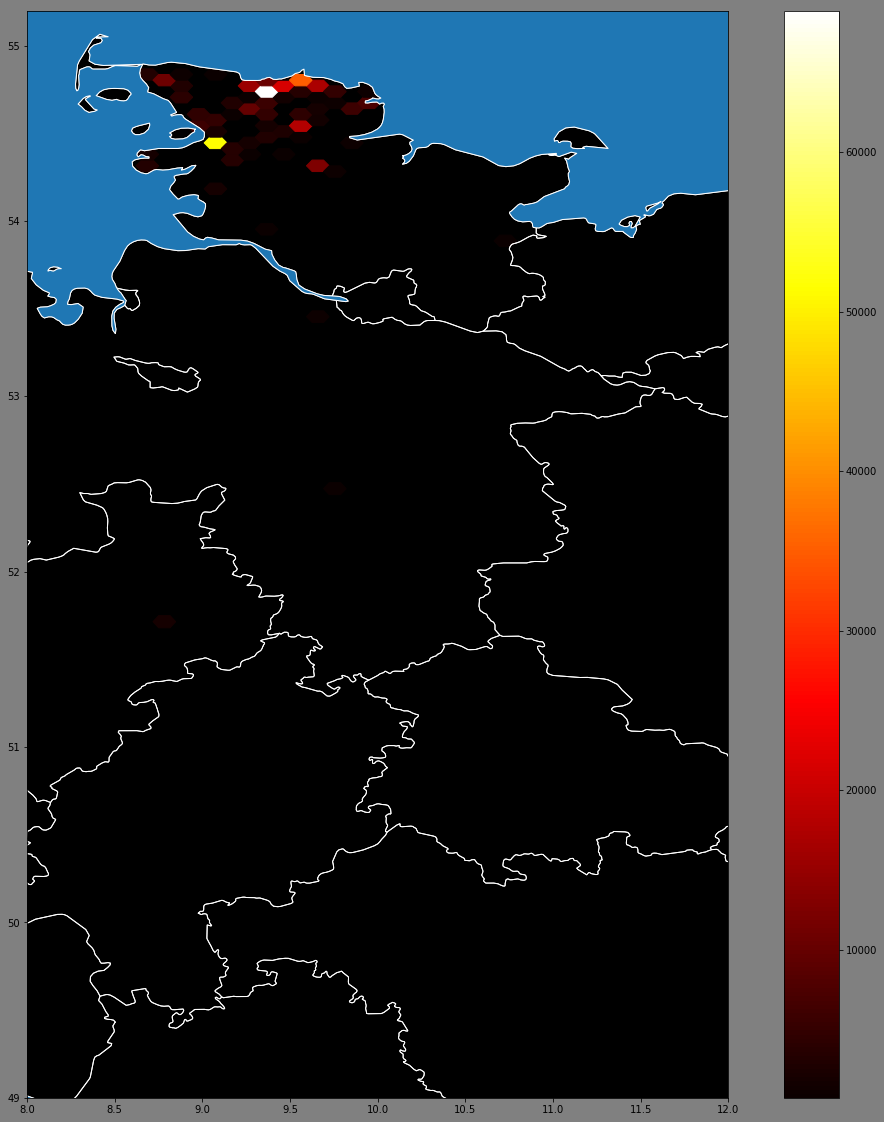

In [42]:
fig, ax = plt.subplots(figsize=(20,20))
fig.set_facecolor('grey')
ax.set_aspect('equal')

gdf_ger_box.plot(ax=ax, edgecolor='black', color='black', facecolor=None, norm=norm, linewidth=1)
gdf_grid_filtered.plot(ax=ax, column='sum', edgecolor='face', cmap='hot', linewidth=1, legend=True)
gdf_ger.plot(ax=ax, color="none", edgecolor='white')
gdf_ger_inv.plot(ax=ax, edgecolor='white', alpha=1.0)

ax.set_ylim([49,55.2])
ax.set_xlim([8,12])
;
